In [24]:
import platform
print(platform.architecture())

('64bit', 'WindowsPE')


In [25]:
!python --version

Python 3.7.6


In [26]:
pwd

'C:\\Users\\sec\\Desktop\\Python_basic'

In [11]:
# 네이버에서 검색어 입력받아 검색 한 후 블로그 메뉴를 선택하고
# 오른쪽에 있는 검색옵션 버튼을 눌러서
# 정렬 방식과 기간을 입력하기

#Step 0. 필요한 모듈과 라이브러리를 로딩합니다.
import sys
import os
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from selenium import webdriver
import time
import tqdm
from tqdm.notebook import tqdm

In [12]:
query_txt = input('1.크롤링할 키워드는 무엇입니까?: ')
# query_txt2 = input('2.제외할 첫번째 키워드를 입력하세요: ')
# query_txt3 = input('3.제외할 두번째 키워드를 입력하세요: '|)

start_date = input('4.조회를 시작할 날짜를 입력하세요(예:20170101) :')
end_date = input('5.조회를 종료할 날짜를 입력하세요(예:20171231): ')

1.크롤링할 키워드는 무엇입니까?: 부산맛집
4.조회를 시작할 날짜를 입력하세요(예:20170101) :20200101
5.조회를 종료할 날짜를 입력하세요(예:20171231): 20200722


In [13]:
#Step 1. 크롬 웹브라우저 실행
path = "chromedriver.exe"   # 윈도우는 "chromedriver.exe"

driver = webdriver.Chrome(path)
# 사이트 주소는 네이버
driver.get('http://www.naver.com')
time.sleep(2)

#Step 2. 네이버 검색창에 "검색어" 검색
element = driver.find_element_by_id("query")
element.send_keys(query_txt)  # query_txt는 위에서 입력한 '이재용'
element.submit()

#Step 3. "블로그" 카테고리 선택
driver.find_element_by_link_text("블로그").click( )    # .click() 괄호 안을 눌러라는 뜻

#Step 4. 오른쪽의 검색 옵션 버튼 클릭
driver.find_element_by_id("_search_option_btn").click( )

#Step 5. 정렬 : "관련도순" 
# 개발자 도구에서 정렬 버튼의 id 가 보이지 않습니다.
# 이럴 경우 쉽게 사용할 수 있는 방법이 바로 xpath 를 이용하는 방법입니다.
# xpath는 개발자 도구에서 해당 메뉴 부분을 마우스 오른쪽 버튼을 누르고 
# copy -> copy xpath 를 선택하면 됩니다
driver.find_element_by_xpath("""//*[@id="snb"]/div/ul/li[1]/a""").click( )  # 정렬 버튼의 xpath 클릭
driver.find_element_by_xpath("""//*[@id="snb"]/div/ul/li[1]/div/ul/li[1]/a""").click( ) # 관련도순 xpath

#Step 6. 날짜 입력
driver.find_element_by_xpath("""//*[@id="snb"]/div/ul/li[2]/a""").click()
time.sleep(2)

# 이 부분이 아주 중요합니다.
# 날짜 부분에 날짜를 입력할 때 입력 속도가 너무 빠를 경우 날짜가 입력이 되다가 
# 오타가 나오는 경우가 많습니다.
# 그래서 날짜를 입력할 때 for 반복문을 사용해서 1 글자씩 입력하도록 코딩했습니다.

# 시작 날짜 입력하기
s_date = driver.find_element_by_xpath("""//*[@id="blog_input_period_begin"]""")     
driver.find_element_by_xpath("""//*[@id="blog_input_period_begin"]""").click()
s_date.clear( )  # 날짜 입력 부분에 기존에 입력되어 있던 날짜를 제거합니다. 
time.sleep(1)
# 아래 코드가 날짜를 for 반복문으로 1 글자씩 입력하는 부분입니다.
for c in start_date:
    s_date.send_keys(c)
    time.sleep(0.1)
    
# 종료 날짜 입력하기
e_date = driver.find_element_by_xpath("""//*[@id="blog_input_period_end"]""")
driver.find_element_by_xpath("""//*[@id="blog_input_period_end"]""").click()
e_date.clear()
time.sleep(1)

for c in end_date:
    e_date.send_keys(c)
    time.sleep(0.1)
    
# Step7. 날짜 입력 "적용하기" 버튼을 클릭 합니다.  
driver.find_element_by_class_name("tx").click()
time.sleep(3)

# # Step 8. 상세 검색버튼을 클릭 후 제외할 단어들을 설정합니다.
# ele2 = driver.find_element_by_id("inpop3")
# ele2.send_keys(query_txt2)
# ele2.send_keys(',')
# ele2.send_keys(query_txt3)
# driver.find_element_by_css_selector(".btn_ft.ty_green._search").click( )

## 글 url 크롤링 시작

In [14]:
url_list = []
title_list = []

# ★몇개의 페이지를 크롤링할지 선택
total_page = 10
for i in tqdm(range(0, total_page)):  # 페이지 번호
    i = i*10 + 1
    url = "https://search.naver.com/search.naver\
?date_from={0}&date_option=8&date_to={1}\
&dup_remove=1&nso=p%3Afrom{2}to{3}post_blogurl=\
&post_blogurl_without=&query={4}&sm=tab_pge&srchby=all&st=sim&where=post&start={5}".format(start_date,end_date,start_date,end_date,query_txt, i)
    driver.get(url)
    time.sleep(0.5)
    
    # URL 크롤링 시작
    titles = "a.sh_blog_title._sp_each_url._sp_each_title"
    article_raw = driver.find_elements_by_css_selector(titles)
#     article_raw

    # url 크롤링 시작    
    for article in article_raw:
        url = article.get_attribute('href')   
        url_list.append(url)
    
    # 제목 크롤링 시작    
    for article in article_raw:
        title = article.get_attribute('title')   
        title_list.append(title)
    
        print(title)
    
print('url갯수: ', len(url_list))
print('url갯수: ', len(title_list))

df = pd.DataFrame({'url':url_list, 'title':title_list})

# 저장하기
df.to_excel("blog_url.xlsx")

기억에 남는 부산 맛집
먹을수록 즐거운 부산 맛집
느낌있는 부산 맛집
[부산 맛집] 골든리지♥
부산 맛집 돈까스 / 광안리 톤쇼우
특별한 부산 맛집!
끝내줬던 부산 맛집
역시 명불허전 부산 맛집
정감가던 부산 맛집
부산 맛집 3found 가치를 높여주는 파스타!
알찼던 부산 맛집
부산 맛집 특별했던 추억!
우리가 인정한 부산 맛집
부산 맛집 대접하기 딱 좋아
특별한 요리였던 부산 맛집
복날엔 부산 맛집
[부산맛집] 해운대 곱창맛집, 소막골
[부산 맛집]성공적 고기말이!
상견례장소로좋은 부산 맛집 베스트
뷰도 끝내주는 부산 맛집
바다가 펼쳐진 부산 맛집
부산 맛집 추천 아쑤라!!!
[부산맛집] 남천동맛집, 히츠마부시(장어덮밥) 고옥
[부산 맛집] 남해 복국 - 참복 풀코스
[부산 맛집]신세계에서 나온 중식당_부산 중식당 화국반점
[부산 맛집] 서면 맛집 - 서면LA갈비 & 서면아롱사태가 맛있는 '서면고기집'
부산 자갈치시장 맛집! 꼼장어, 대게까지! 부산 맛집 리스트 엄마집숯불꼼장어
부산 맛집 럭셔리함을 느껴봐
역시! 부산 맛집
대단한 부산 맛집
부산 맛집 추천 맛있는 아부라소바가 있는 곳
부산 달맞이길 맛집 - 동백샤브샤브, 부산 맛집, 샤브샤브 맛집
부산여행 / 부산맛집 - 섶자리 어부촌 (장어/꼼장어 구이)
갓성비 부산 맛집
출장으로 배운 부산맛집들 해운대 미포끝집, 중앙동 낙지야, 씨앗호떡, 부산횟집, 마카오박, 뚱보집, 명성횟집
꼭 가야하는 부산 맛집
부산 맛집, 부산 해운대 암소갈비
부산 맛집의 부활
부산맛집베스트 고메밀면 남천점 다녀왔어요
부산맛집: 기장 바릇식당 (솔직후기)
[부산맛집]해운대 인기명
[부산맛집/기장맛집] 기장밥집, 가정식맛집, 기장가정식, 미도식당, 다시찾은 미도식당, 명란마요덮밥❣️
진짜 대박인 부산 맛집
부산 맛집 추천 6시간 끓인 전골이 있다
집에서 즐기는 부산 맛집 대창전골
부산 맛집 베스트 보양식 하면 인기명 해운대점이지!
부산맛집 회코스 기장 연화리 극동횟집, 남천동 한우 영남식육식당  - 가족모임, 단체모임으로 좋은식당

# 글 크롤링하기

In [15]:
import sys
import os
import pandas as pd
import numpy as np

In [16]:
# "url_list.csv" 불러오기
url_load = pd.read_excel("blog_url.xlsx")        # 기본 모델

num_list = len(url_load)

print(num_list)
url_load

100


,Unnamed: 0,url,title
0,0,https://blog.naver.com/pakcaptain?Redirect=Log...,기억에 남는 부산 맛집
1,1,https://blog.naver.com/mihee850925?Redirect=Lo...,먹을수록 즐거운 부산 맛집
2,2,https://blog.naver.com/wkdgns1270?Redirect=Log...,느낌있는 부산 맛집
3,3,https://blog.naver.com/busantravel1?Redirect=L...,[부산 맛집] 골든리지♥
4,4,https://blog.naver.com/about_lsj?Redirect=Log&...,부산 맛집 돈까스 / 광안리 톤쇼우
...,...,...,...
95,95,https://blog.naver.com/koreakm1106?Redirect=Lo...,"[부산맛집] 남천동 보성녹차 부산지사, 생활의달인 맛집"
96,96,https://blog.naver.com/00gom?Redirect=Log&logN...,"부산맛집, 동래맛집, 해운대맛집, 철판요리주점 젠닌 고고~"
97,97,https://blog.naver.com/miracle1112?Redirect=Lo...,부산맛집) 느루 한정식
98,98,https://blog.naver.com/zod124?Redirect=Log&log...,금곡동맛집 썬더치킨[순살반반치킨] 부산맛집


In [17]:
dict = {}  # 전체 크롤링 데이터를 담을 그릇

# ★수집할 글 갯수
number = 100
for i in tqdm(range(0, number)): 
    # 글 띄우기
    url = url_load['url'][i]
    driver = webdriver.Chrome("chromedriver.exe")
    driver.get(url)   # 글 띄우기
    
    # 크롤링
    
    try : 
        # iframe 접근
        driver.switch_to_frame('mainFrame')

        target_info = {}

        # 제목 크롤링 시작
        overlays = ".se-fs-.se-ff-"                                 
        tit = driver.find_element_by_css_selector(overlays)         # title
        title = tit.text
        title

        # 글쓴이 크롤링 시작
        overlays = ".nick"                                 
        nick = driver.find_element_by_css_selector(overlays)         # nick
        nickname = nick.text

        # 날짜 크롤링
        overlays = ".se_publishDate.pcol2"                                 
        date = driver.find_element_by_css_selector(overlays)         # date
        datetime = date.text

        # 내용 크롤링
        overlays = ".se-component.se-text.se-l-default"                                 
        contents = driver.find_elements_by_css_selector(overlays)         # date

        content_list = []
        for content in contents:
            content_list.append(content.text)

        content_str = ' '.join(content_list)

        # 글 하나는 target_info라는 딕셔너리에 담기게 되고,
        target_info['title'] = title
        target_info['nickname'] = nickname
        target_info['datetime'] = datetime
        target_info['content'] = content_str

        # 각각의 글은 dict라는 딕셔너리에 담기게 됩니다.
        dict[i] = target_info
        time.sleep(1)
        
        print(i, title)

        # 글 하나 크롤링 후 크롬 창 닫기
        driver.close()       
    
    # 에러나면 현재 크롬창 닫고 다음 글(i+1)로 이동
    except:
        driver.close()
        time.sleep(1)
        continue

print('수집한 글 갯수: ', len(dict))
print(dict)

# 판다스로 만들기
import pandas as pd
result_df = pd.DataFrame.from_dict(dict, 'index')

# 저장하기
result_df.to_excel("blog_content.xlsx")

C:\Users\sec\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: use driver.switch_to.frame instead
  from ipykernel import kernelapp as app


0 지난번 여봉이랑 아가씨와 함께 부산 광안리에 놀러갔다가 부산 맛집에 다녀왔는데염+ㅁ+ 품질좋은 0.5% A급 투뿔 한우식당으로 유명한 곳으로 가격대도 합리적이라 만족했던 곳이었어요~ㅎㅎ
1 주말을 이용해서 애들이랑 부산 맛집으로 불리는 막창집을 다녀왔는데 
3 분위기 좋은 부산 맛집
5 특별한 부산 맛집!
6 끝내줬던 부산 맛집
7 역시 명불허전 부산 맛집
8 정감가던 부산 맛집
9 최근 와이프 고향인 부산 방문 때 코스요리를 먹으러 부산 맛집 3found에 다녀왔습니다.
10 알찼던 부산 맛집
11 
12 우리가 인정한 부산 맛집
13 
14 
16 [부산맛집] 해운대 곱창맛집, 소막골
17 
18 상견례장소로좋은 부산 맛집 베스트
19 뷰도 끝내주는 부산 맛집
20 바다가 펼쳐진 부산 맛집
21 부산 맛집 추천 아쑤라!!!
22 [부산맛집] 남천동맛집, 히츠마부시(장어덮밥) 고옥
23 
24 안냐세여 샨띠에요
25 .
26 부산 자갈치시장 맛집! 꼼장어, 대게까지! 부산 맛집 리스트 엄마집숯불꼼장어
27 부산 맛집 럭셔리함을 느껴봐
28 역시! 부산 맛집
30 
31 부산 달맞이길 맛집 - 동백샤브샤브, 부산 맛집, 샤브샤브 맛집
32 부산여행 / 부산맛집 - 섶자리 어부촌 (장어/꼼장어 구이)
33 갓성비 부산 맛집
35 
36 부산 맛집, 부산 해운대 암소갈비
37 부산 맛집의 부활
38 
39 부산맛집: 기장 바릇식당 (솔직후기)
40 [부산맛집]해운대 인기명
42 진짜 대박인 부산 맛집
43 
44 집에서 즐기는 부산 맛집 대창전골
45 부산 맛집 베스트 보양식 하면 인기명 해운대점이지!
46 부산맛집 회코스 기장 연화리 극동횟집, 
47 부산여행 / 부산맛집 - 차이나 반점
48 [서동맛집/부산맛집] 미로시장 맛나분식 생활의 달인에 나온 계란만두 가성비가 갓성비 
49 부산맛집 다대포 할매집~
50 친구들과 바다도 보고 휴식할 겸
51 혼밥의 제왕  부산 맛집 &카페
52 대창 3
53 부산맛집/광안리맛집 아기랑 함께 톤쇼우광안점
54 미식가인

## 내용 텍스트 분석

In [16]:
# !pip install graphviz
# !pip install konlpy

import scipy as sp
import pandas as pd
import numpy as np

# 사이킷런
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 그래프
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz             
from sklearn.tree import export_graphviz

# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
                                        # 맥 os:  
rc('font', family=font_name)

# 워닝 없애주는 것
import warnings  
warnings.filterwarnings('ignore')

In [2]:
# konlpy : 한글 자연어 처리 라이브러리
from konlpy.tag import Kkma       ; kkma = Kkma()
from konlpy.tag import Hannanum   ; hannanum = Hannanum()
from konlpy.tag import Okt        ; t = Okt()
from konlpy.tag import *
import pickle

In [3]:
df_r = pd.read_excel("blog_content.xlsx")
df_r

,Unnamed: 0,title,nickname,datetime,content
0,0,지난번 여봉이랑 아가씨와 함께 부산 광안리에 놀러갔다가 부산 맛집에 다녀왔는데염+ㅁ...,빙그레요,2020. 6. 16. 13:21,지난번 여봉이랑 아가씨와 함께 부산 광안리에 놀러갔다가 부산 맛집에 다녀왔는데염+ㅁ...
1,1,주말을 이용해서 애들이랑 부산 맛집으로 불리는 막창집을 다녀왔는데,봄날처음\n(mihee850925),2020. 6. 27. 10:30,주말을 이용해서 애들이랑 부산 맛집으로 불리는 막창집을 다녀왔는데 \n이 곳은 가성...
2,3,분위기 좋은 부산 맛집,부산여행특공대,2020. 7. 7. 12:15,"안녕하세요~ 부산여행특공대입니돠!\n며칠 전 친한 친구의 생일이여서, \n좋은 날인..."
3,5,특별한 부산 맛집!,그루터기\n(hloveh01),2020. 5. 31. 21:33,며칠 전 친구에게 좋은 일이 생겨 축하 겸 \n특별한 부산 맛집을 찾았다.\n미슐랭...
4,6,끝내줬던 부산 맛집,앨리스전\n(feelwa212),2020. 7. 21. 11:01,얼마 전에 절친을 만나러 갔다가\n맛있는 저녁을 먹었던 부산 맛집을 알려드릴까 합니...
...,...,...,...,...,...
83,95,"[부산맛집] 남천동 보성녹차 부산지사, 생활의달인 맛집",미니어쳐\n(koreakm1106),2020. 6. 3. 16:50,부산 남천동은 빵천동으로 불릴절도로 빵집이 참 많은데요.\n그 중 빵집은 아니지만\...
84,96,"부산맛집, 동래맛집, 해운대맛집, 철판요리주점 젠닌 고고~",미객,2020. 6. 19. 21:33,"부산맛집, 동래맛집, 해운대맛집\n손맛의 달인이 운영하는 철판요리주점\n'젠닌'\n..."
85,97,부산맛집) 느루 한정식,요니마마,2020. 7. 16. 22:10,무더운 여름\n곧 휴가철이 다가오네요\n올 여름 휴가는 국내여행으로 많이 가실텐데\...
86,98,금곡동맛집 썬더치킨[순살반반치킨] 부산맛집,Kkang,2020. 6. 29. 11:55,금곡동맛집 썬더치킨[순살반반치킨] 부산맛집\n안녕하세요 Kkang's 입니다\n이번...


In [4]:
df_r['content']

0     지난번 여봉이랑 아가씨와 함께 부산 광안리에 놀러갔다가 부산 맛집에 다녀왔는데염+ㅁ...
1     주말을 이용해서 애들이랑 부산 맛집으로 불리는 막창집을 다녀왔는데 \n이 곳은 가성...
2     안녕하세요~ 부산여행특공대입니돠!\n며칠 전 친한 친구의 생일이여서, \n좋은 날인...
3     며칠 전 친구에게 좋은 일이 생겨 축하 겸 \n특별한 부산 맛집을 찾았다.\n미슐랭...
4     얼마 전에 절친을 만나러 갔다가\n맛있는 저녁을 먹었던 부산 맛집을 알려드릴까 합니...
                            ...                        
83    부산 남천동은 빵천동으로 불릴절도로 빵집이 참 많은데요.\n그 중 빵집은 아니지만\...
84    부산맛집, 동래맛집, 해운대맛집\n손맛의 달인이 운영하는 철판요리주점\n'젠닌'\n...
85    무더운 여름\n곧 휴가철이 다가오네요\n올 여름 휴가는 국내여행으로 많이 가실텐데\...
86    금곡동맛집 썬더치킨[순살반반치킨] 부산맛집\n안녕하세요 Kkang's 입니다\n이번...
87     7월 초에 사촌언니랑 둘이 부산을 다녀왔습니다.\n대중교통이 좀 위험헐 것 같아서...
Name: content, Length: 88, dtype: object

In [5]:
content_list = df_r.content.values.tolist()

print(len(content_list))
content_list

88


['지난번 여봉이랑 아가씨와 함께 부산 광안리에 놀러갔다가 부산 맛집에 다녀왔는데염+ㅁ+ 품질좋은 0.5% A급 투뿔 한우식당으로 유명한 곳으로 가격대도 합리적이라 만족했던 곳이었어요~ㅎㅎ 이 날 방문한 더좋은한우는 광안리해변에서 차로 1분걸려 도착했는데염. 해변 끝자락 방파제 쪽에 위치해 있다보니 바다 구경하고 방문하기에 딱 좋았어요ㅎㅎ 게다가 이렇게 바다를 마주보는 자리라 가게 안에서 오션뷰를 즐길 수 있어 분위기도 무척 좋더라구요ㅎㅎ 주차는 건물 내 지하주차장을 이용 할 수 있었는데요~ 2시간 무료주차가 가능해서 식사하는 동안 편하게 차를 세워 둘 수 있었어요ㅎㅎ 주차 후 안으로 들어가니 실내는 모두 입식석으로 마련되어 있었어요~ 공간이 나뉘어져 있어서 부산 맛집은 각종 모임이나 단체로 방문하기에도 괜찮겠더라구요ㅎㅎ 또 안쪽으로 들어가면 테라스석도 있었는데염. 창밖 풍경이 훤히 보이는 통유리창으로 되어 있어 운치있게 즐기기에 좋았답니당~^0^ 한켠에는 와인셀러도 보였어요. 고급품질의 한우를 취급하는 식당이라 잘 어울리는 다양한 와인들도 구비해 두었더라구요ㅎㅎ 벽면에 와인가격이 적혀있었는데 고급 프리미오 와인을 저렴하게 2만원에 판매하고 있어서 회식장소로도 인기가 많은 곳이었습니당ㅎㅎ  메뉴판을 보며 저희는 한우 특수모듬을 주문했어요. 부산 맛집은 A급 한우투뿔 전문점이라 특수부위가 가장 대표메뉴더라구요.  주문을 마치니 식기와 함께 상차림이 시작되었어요. 일회용 물티슈와 소독포장이 된 수저세트로 깔끔하게 준비해주셔서 위생도 안심이 되더라구염~>0< 이어서 화구에 숯이 안착되었어요. 화구는 상향식 화로여서 흡입력이 강하다보니 식사하는 동안 연기로 인한 불편함이 없어서 마음에 들었답니다. 동시에 밑반찬도 하나 둘씩 차려졌고 먼저 콘샐러드부터 맛보았어요. 다진야채와 함께 옥수수를 마요네즈에 되직하게 버무려져 식전 애피타이저로 제격이었어요. 부산 맛집은 반찬 가짓수가 다양한 편은 아니었지만 모두 고기와 잘 어울리는 백김치나 장아찌등 절임류로 제공 되어서 식사 내

In [6]:
# 자연어 처리 natural language too kit
import nltk
from konlpy.tag import Okt; t = Okt()

In [7]:
# 리스트 중 str 타입이 아닌 요소들이 존재함을 확인
for i in content_list:
    if type(i) == float:
        i = str(i)
        print(i)

In [8]:
# str 타입이 아닌 요소들이 있으면 전부 str 타입으로 바꿔라!
for i in range(len(content_list)):
    if type(content_list[i]) != str:
        content_list[i] = str(content_list[i])

In [9]:
content_text = ''

for each_line in content_list[:2000]:
    content_text = content_text + each_line + '\n'

In [10]:
content_text

'지난번 여봉이랑 아가씨와 함께 부산 광안리에 놀러갔다가 부산 맛집에 다녀왔는데염+ㅁ+ 품질좋은 0.5% A급 투뿔 한우식당으로 유명한 곳으로 가격대도 합리적이라 만족했던 곳이었어요~ㅎㅎ 이 날 방문한 더좋은한우는 광안리해변에서 차로 1분걸려 도착했는데염. 해변 끝자락 방파제 쪽에 위치해 있다보니 바다 구경하고 방문하기에 딱 좋았어요ㅎㅎ 게다가 이렇게 바다를 마주보는 자리라 가게 안에서 오션뷰를 즐길 수 있어 분위기도 무척 좋더라구요ㅎㅎ 주차는 건물 내 지하주차장을 이용 할 수 있었는데요~ 2시간 무료주차가 가능해서 식사하는 동안 편하게 차를 세워 둘 수 있었어요ㅎㅎ 주차 후 안으로 들어가니 실내는 모두 입식석으로 마련되어 있었어요~ 공간이 나뉘어져 있어서 부산 맛집은 각종 모임이나 단체로 방문하기에도 괜찮겠더라구요ㅎㅎ 또 안쪽으로 들어가면 테라스석도 있었는데염. 창밖 풍경이 훤히 보이는 통유리창으로 되어 있어 운치있게 즐기기에 좋았답니당~^0^ 한켠에는 와인셀러도 보였어요. 고급품질의 한우를 취급하는 식당이라 잘 어울리는 다양한 와인들도 구비해 두었더라구요ㅎㅎ 벽면에 와인가격이 적혀있었는데 고급 프리미오 와인을 저렴하게 2만원에 판매하고 있어서 회식장소로도 인기가 많은 곳이었습니당ㅎㅎ  메뉴판을 보며 저희는 한우 특수모듬을 주문했어요. 부산 맛집은 A급 한우투뿔 전문점이라 특수부위가 가장 대표메뉴더라구요.  주문을 마치니 식기와 함께 상차림이 시작되었어요. 일회용 물티슈와 소독포장이 된 수저세트로 깔끔하게 준비해주셔서 위생도 안심이 되더라구염~>0< 이어서 화구에 숯이 안착되었어요. 화구는 상향식 화로여서 흡입력이 강하다보니 식사하는 동안 연기로 인한 불편함이 없어서 마음에 들었답니다. 동시에 밑반찬도 하나 둘씩 차려졌고 먼저 콘샐러드부터 맛보았어요. 다진야채와 함께 옥수수를 마요네즈에 되직하게 버무려져 식전 애피타이저로 제격이었어요. 부산 맛집은 반찬 가짓수가 다양한 편은 아니었지만 모두 고기와 잘 어울리는 백김치나 장아찌등 절임류로 제공 되어서 식사 내내

## 형태소분석을 마친 단어로 만든 token_ko

In [11]:
# konlpy라는 라이브러리에 Okt 모듈(=t) 중에 
# morph라는 메소드를 사용 -> 글을 쪼개서 형태소 분석
# nouns -> 명사만 가져오기
tokens_ko = t.morphs(content_text)
tokens_ko

['지난번',
 '여',
 '봉',
 '이랑',
 '아가씨',
 '와',
 '함께',
 '부산',
 '광안',
 '리',
 '에',
 '놀러',
 '갔다가',
 '부산',
 '맛집',
 '에',
 '다녀왔는데',
 '염',
 '+',
 'ㅁ',
 '+',
 '품질',
 '좋은',
 '0.5%',
 'A',
 '급',
 '투뿔',
 '한우',
 '식당',
 '으로',
 '유명한',
 '곳',
 '으로',
 '가격',
 '대도',
 '합리',
 '적',
 '이라',
 '만족했던',
 '곳',
 '이었어요',
 '~',
 'ㅎㅎ',
 '이',
 '날',
 '방문',
 '한',
 '더',
 '좋은',
 '한우',
 '는',
 '광안',
 '리',
 '해변',
 '에서',
 '차로',
 '1분',
 '걸려',
 '도착',
 '했는데',
 '염',
 '.',
 '해변',
 '끝',
 '자락',
 '방파제',
 '쪽',
 '에',
 '위치',
 '해',
 '있다',
 '보니',
 '바다',
 '구경',
 '하고',
 '방문',
 '하기에',
 '딱',
 '좋았어요',
 'ㅎㅎ',
 '게다가',
 '이렇게',
 '바다',
 '를',
 '마주',
 '보는',
 '자리',
 '라',
 '가게',
 '안',
 '에서',
 '오션',
 '뷰',
 '를',
 '즐길',
 '수',
 '있어',
 '분위기',
 '도',
 '무척',
 '좋더라구요',
 'ㅎㅎ',
 '주차',
 '는',
 '건물',
 '내',
 '지하',
 '주차장',
 '을',
 '이용',
 '할',
 '수',
 '있었는데요',
 '~',
 '2시간',
 '무료',
 '주차',
 '가',
 '가능해서',
 '식사',
 '하는',
 '동안',
 '편하게',
 '차',
 '를',
 '세워',
 '둘',
 '수',
 '있었어요',
 'ㅎㅎ',
 '주차',
 '후',
 '안',
 '으로',
 '들어가니',
 '실내',
 '는',
 '모두',
 '입',
 '식',
 '석',
 '으로',
 '마련',
 '되어',
 '있었어요',


In [12]:
ko = nltk.Text(tokens_ko)   
print(len(ko.tokens))          # 토큰 전체 갯수
print(len(set(ko.tokens)))     # 토큰 unique 갯수

66775
11135


In [13]:
# 토큰 빈도수 확인
ko = nltk.Text(tokens_ko)
ko.vocab().most_common(100)    # 가장 많이 나온 단어 100개

[('\n', 3772),
 ('.', 2044),
 ('이', 1649),
 ('에', 1170),
 ('을', 856),
 ('가', 846),
 ('도', 723),
 (',', 620),
 ('부산', 570),
 ('은', 545),
 ('를', 511),
 ('는', 498),
 ('한', 476),
 ('으로', 429),
 ('의', 422),
 ('맛집', 421),
 ('로', 402),
 ('!', 376),
 ('들', 373),
 ('수', 339),
 ('맛', 335),
 ('곳', 308),
 ('것', 288),
 ('에서', 232),
 ('~', 226),
 ('과', 216),
 ('있는', 216),
 ('와', 207),
 ('다', 206),
 ('하고', 198),
 ('잘', 198),
 ('까지', 187),
 ('더', 179),
 ('만', 178),
 ('너무', 174),
 ('정말', 171),
 ('주문', 164),
 ('?', 164),
 ('-', 162),
 ('..', 155),
 ('적', 153),
 ('안', 149),
 ('나', 148),
 ('고', 144),
 ('요', 127),
 ('고기', 126),
 ('인', 126),
 ('있어서', 121),
 ('그', 121),
 ('해서', 121),
 ('그리고', 120),
 ('집', 120),
 ('저', 118),
 ('하나', 118),
 ('먹을', 118),
 ('에는', 118),
 ('부터', 113),
 ('진짜', 112),
 ('좋은', 110),
 ('할', 110),
 ('함께', 109),
 ('때', 109),
 ('게', 107),
 ('음식', 107),
 ('...', 105),
 ('ㅎㅎ', 104),
 ('먹고', 104),
 ('먹어', 102),
 ('생각', 102),
 ('소스', 99),
 ('밥', 98),
 ('바로', 98),
 ('제', 95),
 ('곱창', 94),
 ('요

In [29]:
# 불용어 : 인터넷 검색 시 검색 용어로 사용하지 않는 단어. 관사, 전치사, 조사, 접속사 등 검색 색인 단어로 의미가 없는 단어
stop_words = [')','?','1','"(', '_', ')/','\n','.',',', '<','!','(','(', '??','..', '4', '|', '>', '?(', '"…', '#',
              '&', '・', "']",'.',' ','/',"'",'’','”','“','·', '[','!','\n','·','‘','"','\n ',']',':','…',')',
              '(','-', 'nan','가','요','답변','...','을','수','에','질문','제','를','이','도', '좋','1','는','로',
              '으로','2','것','은','다',',','니다','대','들','2017','들','데','..','의','때','겠','고','게','네요',
              '한','일','할','10','?','하는','06','주','려고','인데','거','좀','는데','~','ㅎㅎ','하나','이상','20',
              '뭐','까','있는','잘','습니다','다면','했','주려','지','있','못','후','중','줄','6','과','어떤','기본',
              '!!','단어','라고','중요한','합','가요','....','보이','네','무지','했습니다','이다','대해','에게','입니다',
              '있다','사람','대한','3','합니다','및','장','에서','하고','검','한다','만','적','성','삼','등','전','인',
              '그','했다','와','위','해','권','된','서','말','분','맛','곳','더','안','나','집','저','밥', '면','입',
              '너무','정말','까지','해서','에는','진짜','부터','또','기','하']

tokens_ko = [each_word for each_word in tokens_ko
             if each_word not in stop_words]

ko = nltk.Text(tokens_ko)
ko.vocab().most_common(50)

[('부산', 570),
 ('맛집', 421),
 ('주문', 164),
 ('고기', 126),
 ('있어서', 121),
 ('그리고', 120),
 ('먹을', 118),
 ('좋은', 110),
 ('함께', 109),
 ('음식', 107),
 ('먹고', 104),
 ('먹어', 102),
 ('생각', 102),
 ('소스', 99),
 ('바로', 98),
 ('곱창', 94),
 ('요리', 94),
 ('저희', 93),
 ('메뉴', 93),
 ('이렇게', 91),
 ('많이', 86),
 ('있었어요', 84),
 ('먹기', 84),
 ('했어요', 83),
 ('양념', 83),
 ('먹는', 83),
 ('먹으면', 80),
 ('추천', 78),
 ('시간', 77),
 ('느낌', 75),
 ('정도', 73),
 ('에도', 73),
 ('같아요', 72),
 ('되어', 71),
 ('보다', 68),
 ('라', 67),
 ('향', 66),
 ('같이', 66),
 ('맛있는', 66),
 ('여기', 66),
 ('친구', 66),
 ('이랑', 65),
 ('가격', 65),
 ('식사', 64),
 ('그냥', 64),
 ('때문', 64),
 ('국물', 63),
 ('엄청', 63),
 ('다음', 63),
 ('이라', 62)]

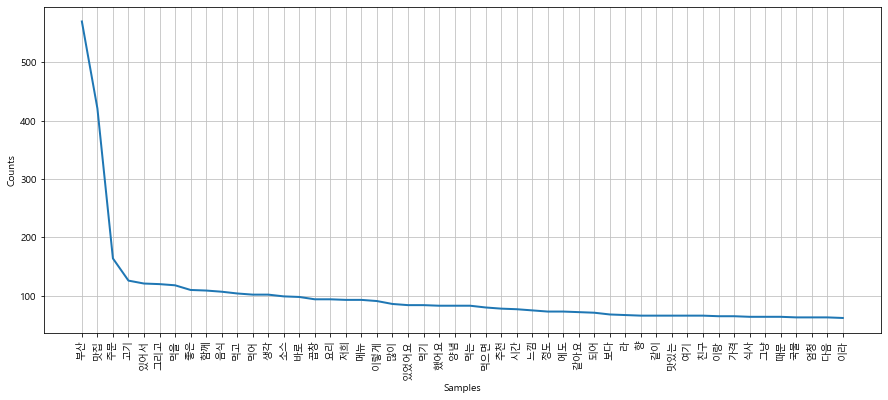

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz             
from sklearn.tree import export_graphviz
plt.figure(figsize=(15,6))
ko.plot(50) 
plt.show()

# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

In [31]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [32]:
data = ko.vocab().most_common(300)

print(len(data))
data

300


[('부산', 570),
 ('맛집', 421),
 ('주문', 164),
 ('고기', 126),
 ('있어서', 121),
 ('그리고', 120),
 ('먹을', 118),
 ('좋은', 110),
 ('함께', 109),
 ('음식', 107),
 ('먹고', 104),
 ('먹어', 102),
 ('생각', 102),
 ('소스', 99),
 ('바로', 98),
 ('곱창', 94),
 ('요리', 94),
 ('저희', 93),
 ('메뉴', 93),
 ('이렇게', 91),
 ('많이', 86),
 ('있었어요', 84),
 ('먹기', 84),
 ('했어요', 83),
 ('양념', 83),
 ('먹는', 83),
 ('먹으면', 80),
 ('추천', 78),
 ('시간', 77),
 ('느낌', 75),
 ('정도', 73),
 ('에도', 73),
 ('같아요', 72),
 ('되어', 71),
 ('보다', 68),
 ('라', 67),
 ('향', 66),
 ('같이', 66),
 ('맛있는', 66),
 ('여기', 66),
 ('친구', 66),
 ('이랑', 65),
 ('가격', 65),
 ('식사', 64),
 ('그냥', 64),
 ('때문', 64),
 ('국물', 63),
 ('엄청', 63),
 ('다음', 63),
 ('이라', 62),
 ('랑', 62),
 ('자리', 61),
 ('점', 61),
 ('아주', 61),
 ('방문', 60),
 ('있어', 60),
 ('딱', 59),
 ('역시', 59),
 ('좋았어요', 58),
 ('식', 58),
 ('두', 58),
 ('다른', 58),
 ('찍어', 57),
 ('소', 57),
 ('아', 55),
 ('분위기', 54),
 ('라면', 54),
 ('이에요', 54),
 ('회', 54),
 ('야채', 53),
 ('추가', 53),
 ('층', 53),
 ('꼭', 53),
 ('날', 52),
 ('먼저', 52),
 ('처음', 52),

In [33]:
# list tuple을 딕셔너리로 만들어주는 함수
def todict(list_tuple):    
    todict = {}
    for i in range(0,len(list_tuple)):
        todict[data[i][0]] = data[i][1]
    return todict

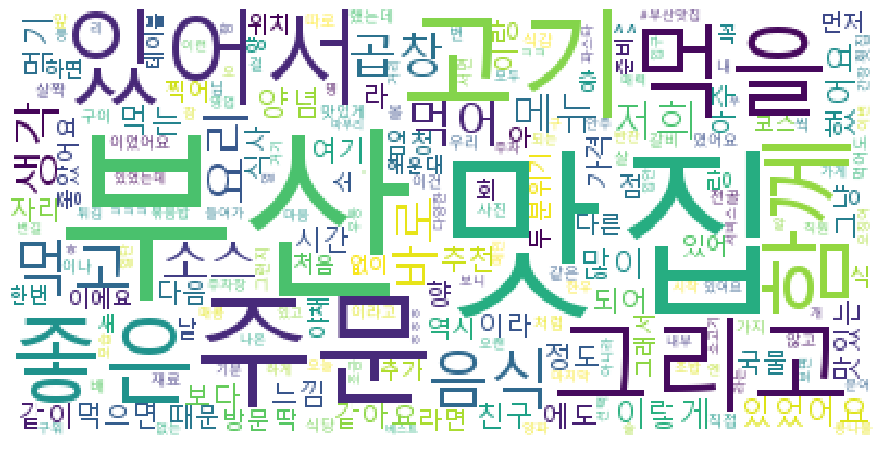

In [44]:
# 워드클라우드를 그려보자
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling = 0.1,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(todict(data))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()